In [1]:
#import necessary packages
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import matplotlib.pyplot as plt

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
#reset tf graph
tf.reset_default_graph()

In [3]:
#read data and split labels from values
initial = (pd.read_csv('/content/drive/My Drive/GSE99095_normalizedExpression.csv',header=None)).T
#create labels
initial[0]=np.zeros(980)
for i in range(1,392):
    (initial[0].values)[i]=1

initial=initial.iloc[1:]
labels= initial[0].values
values = (initial.drop((initial[0]),axis=1)).values

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252

In [0]:
#randomly shuffle data and do a train-test split on values and labels
values, labels = shuffle(values, labels,random_state=1) 
values_train = values[:700, :]
values_test = values[700:, :]
y_train = labels[:700]
y_test = labels[700:]

In [0]:
#train the RF with 400 trees and make predictions
rf = RandomForestClassifier(n_estimators=400, n_jobs=-1)
rf.fit(values_train, y_train)
acc_rf = 1 - sum(abs(rf.predict(values_test)-y_test))/len(y_test)

x_total = [tree.predict(values) for tree in rf.estimators_]

In [0]:
#one-hot encode the features 
x_total = np.transpose(x_total)
x_train = []
for sample in x_total:
    s = []
    for feature in sample:
        if feature == 1:
            s.append([0, 1])
        else:
            s.append([1, 0])
    x_train.append(s)
x_train = np.array(x_train)
x_test = x_train[700:, :] 
x_train = x_train[:700, :]

In [0]:
#one-hot encode the labels
labelss = []
for l in labels:
    if l == 1:
        labelss.append([0, 1])
    else:
        labelss.append([1, 0])
labelss = np.array(labelss,dtype=int)

y_train = labelss[:700, :]
y_test = labelss[700:, :]
auc_rf = metrics.roc_auc_score(y_test, rf.predict_proba(values_test))

In [0]:
#nn parameter initialization
L2 = True 
droph1 = False
learning_rate = 0.0001
training_epochs = 200
batch_size = 8
display_step = 1

n_hidden_1 = 256
n_hidden_2 = 64
n_hidden_3 = 16
n_classes = 2
n_features = np.shape(x_train)[1]

loss_rec = np.zeros([training_epochs, 1])
training_eval = np.zeros([training_epochs, 2])

avg_test_acc = 0.
avg_test_auc = 0.

In [0]:
#define the nn architecture
def multilayer_perceptron(x, weights, biases, keep_prob):

    layer_1 = tf.add(tf.tensordot(x, weights['h1'], axes=[[1, 2],[0, 1]]), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    if droph1:
        layer_1 = tf.nn.dropout(layer_1, keep_prob=keep_prob)

    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    layer_2 = tf.nn.dropout(layer_2, keep_prob=keep_prob)

    layer_3 = tf.add(tf.matmul(layer_2, weights['h3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
    layer_3 = tf.nn.dropout(layer_3, keep_prob=keep_prob)

    out_layer = tf.matmul(layer_3, weights['out']) + biases['out']
    return out_layer

In [0]:
#weights and biases
x = tf.placeholder(tf.float32, [None, n_features, 2])
y = tf.placeholder(tf.int32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32)
lr = tf.placeholder(tf.float32)

weights = {
    'h1': tf.Variable(tf.truncated_normal(shape=[2, n_features, n_hidden_1], stddev=0.1)),
    'h2': tf.Variable(tf.truncated_normal(shape=[n_hidden_1, n_hidden_2], stddev=0.1)),
    'h3': tf.Variable(tf.truncated_normal(shape=[n_hidden_2, n_hidden_3], stddev=0.1)),
    'out': tf.Variable(tf.truncated_normal(shape=[n_hidden_3, n_classes], stddev=0.1))

}

biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'b2': tf.Variable(tf.zeros([n_hidden_2])),
    'b3': tf.Variable(tf.zeros([n_hidden_3])),
    'out': tf.Variable(tf.zeros([n_classes]))
}

In [11]:
#build the model
pred = multilayer_perceptron(x, weights, biases, keep_prob)

#model cost and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
if L2:
    reg = tf.nn.l2_loss(weights['h1']) + tf.nn.l2_loss(weights['h2']) + \
          tf.nn.l2_loss(weights['h3']) + tf.nn.l2_loss(weights['out'])
    cost = tf.reduce_mean(cost + 0.1 * reg)
optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)

#evaluation
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
y_score = tf.nn.softmax(logits=pred)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [12]:
#train the model
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())
    total_batch = int(np.shape(x_train)[0] / batch_size)

    for epoch in range(training_epochs):
        avg_cost = 0.
        x_tmp, y_tmp = shuffle(x_train, y_train,random_state=1)
        # Loop over all batches
        for i in range(total_batch-1):
            batch_x, batch_y = x_tmp[i*batch_size:i*batch_size+batch_size], \
                                y_tmp[i*batch_size:i*batch_size+batch_size]
            _, c= sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y,
                                                        keep_prob: 0.9,
                                                        lr: learning_rate
                                                        })  
            avg_cost += c / total_batch

        del x_tmp
        del y_tmp

        if epoch % display_step == 0:
            loss_rec[epoch] = avg_cost
            acc, y_s = sess.run([accuracy, y_score], feed_dict={x: x_train, y: y_train, keep_prob: 1})
            auc = metrics.roc_auc_score(y_train, y_s)
            training_eval[epoch] = [acc, auc]
            print ("Epoch:", '%d' % (epoch+1), "cost =", "{:.9f}".format(avg_cost),
                    "Training accuracy:", round(acc,3), " Training auc:", round(auc,3))
        if avg_cost <= 0.1:
            break  

#test the model and evaluate
    acc, y_s = sess.run([accuracy, y_score], feed_dict={x: x_test, y: y_test, keep_prob: 1})
    auc = metrics.roc_auc_score(y_test, y_s)
    print("*****=====", "Testing accuracy: ", acc, " Testing auc: ", auc, "=====*****")
    print(auc)
    print(auc_rf)                                                   

Epoch: 1 cost = 79.342366186 Training accuracy: 1.0  Training auc: 1.0
Epoch: 2 cost = 67.634769703 Training accuracy: 1.0  Training auc: 1.0
Epoch: 3 cost = 57.665784112 Training accuracy: 1.0  Training auc: 1.0
Epoch: 4 cost = 49.150822124 Training accuracy: 1.0  Training auc: 1.0
Epoch: 5 cost = 41.863398059 Training accuracy: 1.0  Training auc: 1.0
Epoch: 6 cost = 35.613442081 Training accuracy: 1.0  Training auc: 1.0
Epoch: 7 cost = 30.260460470 Training accuracy: 1.0  Training auc: 1.0
Epoch: 8 cost = 25.671587845 Training accuracy: 1.0  Training auc: 1.0
Epoch: 9 cost = 21.742701563 Training accuracy: 1.0  Training auc: 1.0
Epoch: 10 cost = 18.368577365 Training accuracy: 1.0  Training auc: 1.0
Epoch: 11 cost = 15.494101787 Training accuracy: 1.0  Training auc: 1.0
Epoch: 12 cost = 13.033642725 Training accuracy: 1.0  Training auc: 1.0
Epoch: 13 cost = 10.937707846 Training accuracy: 1.0  Training auc: 1.0
Epoch: 14 cost = 9.153740839 Training accuracy: 1.0  Training auc: 1.0
Ep

In [0]:
values_train = values[:700, :]
values_test = values[700:, :]
y_train = labels[:700]
y_test = labels[700:]

In [14]:
#RF with 1000 trees
rf2 = RandomForestClassifier(n_estimators=1000, n_jobs=-1)
rf2.fit(values_train, y_train)
acc_rf2 = 1 - sum(abs(rf2.predict(values_test)-y_test))/len(y_test)
auc_rf2 = metrics.roc_auc_score(y_test, rf2.predict(values_test))
auc_rf2

0.952754835905238

In [15]:
#SVM with Sigmoid kernel
clf = svm.SVC()
clf.fit(values_train, y_train)
acc_clf = 1 - sum(abs(clf.predict(values_test)-y_test))/len(y_test)
auc_clf = metrics.roc_auc_score(y_test, clf.predict(values_test))
print(auc_clf)

0.9772603781786569


In [16]:
#linear SVM with full features
linear_clf = svm.LinearSVC()
linear_clf.fit(values_train,y_train)
acc_linear_clf = 1 - sum(abs(linear_clf.predict(values_test)-y_test))/len(y_test)
auc_linear_clf = metrics.roc_auc_score(y_test, linear_clf.predict(values_test))
print(auc_linear_clf)

0.974978265594436


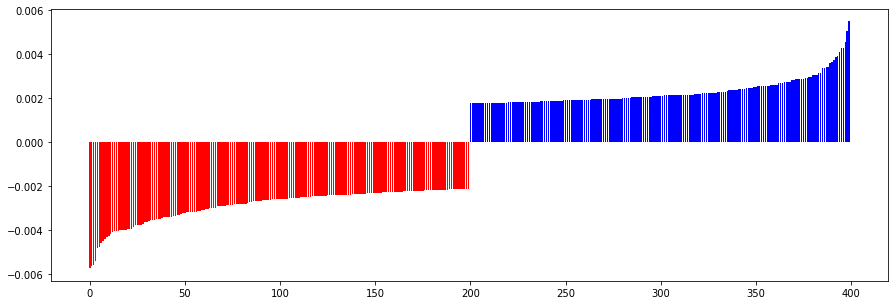

In [17]:
#detect important features
def plot_coefficients(classifier, top_features=200):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

 plt.figure(figsize=(15, 5))
 colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 plt.show()
 return(top_coefficients) 


top_features = plot_coefficients(linear_clf)

In [0]:
#Feature Selection
compressed = initial.iloc[:,top_features]
values = compressed.values
values, labels = shuffle(values, labels,random_state=1) 
values_train2 = values[:700, :]
values_test2 = values[700:, :]
y_train2 = labels[:700]
y_test2 = labels[700:]

In [19]:
#linear SVM with selected features
linear_clf2 = svm.LinearSVC()
linear_clf2.fit(values_train2,y_train2)
acc_linear_clf2 = 1 - sum(abs(linear_clf2.predict(values_test2)-y_test2))/len(y_test2)
auc_linear_clf2 = metrics.roc_auc_score(y_test2, linear_clf2.predict(values_test2))
print(auc_linear_clf2)

0.4957726109689621


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [20]:
#comparison
RF_auc = pd.DataFrame({'RF with 500 Tress':[auc_rf],'RF with 1000 Tress':[auc_rf2]})
fdnn_svd_auc = pd.DataFrame({'fDNN':[auc],'Sigmoid SVM':[auc_clf],'Full Linear SVM':[auc_linear_clf],'FS Linear SVM':[auc_linear_clf2]})
print(RF_auc)
print(fdnn_svd_auc)

   RF with 500 Tress  RF with 1000 Tress
0           0.993969            0.952755
       fDNN  Sigmoid SVM  Full Linear SVM  FS Linear SVM
0  0.994023      0.97726         0.974978       0.495773
